## <b><font color='darkblue'>Preface</font></b>
([source](https://realpython.com/langgraph-python/?fbclid=IwZXh0bgNhZW0CMTEAAR6wBnQpFfskJnubHhtPKpXLUjnoDzFtpHy2cwGMmslw5lZyysdVxaC6UyuatA_aem_ytzTtBvnm47u4-OB0E_dkw)) <font size='3ptx'><b>[LangGraph](https://www.langchain.com/langgraph) is a versatile Python library designed for stateful, cyclic, and multi-actor [**Large Language Model**](https://en.wikipedia.org/wiki/Large_language_model) (LLM) applications</b>. LangGraph builds upon its parent library, [**LangChain**](https://www.langchain.com/), and allows you to build sophisticated workflows that are capable of handling the complexities of real-world LLM applications.</font>

By the end of this tutorial, you’ll understand that:
* You can use [**LangGraph**](https://www.langchain.com/langgraph) to build LLM workflows by defining state graphs with nodes and edges.
* [**LangGraph**](https://www.langchain.com/langgraph) expands [**LangChain**](https://www.langchain.com/)’s capabilities by providing tools to build complex LLM workflows with state, conditional edges, and cycles.
* LLM agents in [**LangGraph**](https://www.langchain.com/langgraph) autonomously process tasks using state graphs to make decisions and interact with tools or APIs.
* You can use [**LangGraph**](https://www.langchain.com/langgraph) independently of [**LangChain**](https://www.langchain.com/), although they’re often used together to complement each other.


Explore the full tutorial to gain hands-on experience with [**LangGraph**](https://www.langchain.com/langgraph), including setting up workflows and building a LangGraph agent that can autonomously parse emails, send emails, and interact with API services.


While you’ll get a brief primer on [**LangChain**](https://www.langchain.com/) in this tutorial, you’ll benefit from having prior knowledge of LangChain fundamentals. You’ll also want to ensure you have intermediate Python knowledge—specifically in object-oriented programming concepts like classes and methods.

In [1]:
from IPython.display import Image

### <b><font color='darkgreen'>Install LangGraph</font></b>
LangGraph is available on PyPI, and you can install it with pip. Open a terminal or command prompt, create a new virtual environment, and then run the following command:
```shell
(venv) $ python -m pip install langgraph
```

In [1]:
!pip freeze | grep langgraph

langgraph==0.3.21
langgraph-checkpoint==2.0.23
langgraph-prebuilt==0.1.7
langgraph-sdk==0.1.60


You’ll also need a few more libraries for this tutorial:
```shell
(venv) $ pip install langchain-openai "pydantic[email]"
```

In [2]:
!pip freeze | grep -P '(langchain-openai|pydantic)'

langchain-openai==0.3.11
pydantic==2.10.6
pydantic-settings==2.8.1
pydantic_core==2.27.2


You’ll use [`langchain-openai`](https://github.com/langchain-ai/langchain) to interact with OpenAI LLMs, but keep in mind that **you can use any LLM provider you like with LangGraph and LangChain**. You’ll **use [pydantic](https://realpython.com/python-pydantic/) to validate the information your agent parses from emails**.

Before moving forward, if you choose to use OpenAI, make sure you’re signed up for an OpenAI account and that you have a valid [**API key**](https://openai.com/api/). You’ll need to set the following [environment variable](https://en.wikipedia.org/wiki/Environment_variable) before running any examples in this tutorial:
```shell
OPENAI_API_KEY=<YOUR-OPENAI-API-KEY>
```

Note that while LangGraph was made by the creators of LangChain, and the two libraries are highly compatible, it’s possible to use LangGraph without LangChain. However, it’s more common to use LangChain and LangGraph together, and you’ll see throughout this tutorial how they complement each other.

In [2]:
import os
from dotenv import load_dotenv, find_dotenv

# We defined the environment variable `OPENAI_API_KEY` in `~/.env`
_ = load_dotenv(find_dotenv(os.path.expanduser('~/.env')))

<b>With that, you’ve installed all the dependencies you’ll need for this tutorial, and you’re ready to create your LangGraph email processor</b>. Before diving in, you’ll take a brief detour to set up quick sanity tests for your app. Then, <b>you’ll go through an overview of LangChain chains and explore LangGraph’s core concept—the state graph</b>.

### <b><font color='darkgreen'>Create Test Cases</font></b>
<font size='3ptx'><b>When developing AI applications, testing and performance tracking is crucial for understanding how your chain, graph, or agent performs in the real world.</b> While performance tracking is out of scope for this tutorial, you’ll use several example emails to test your chains, graphs, and agent, and you’ll empirically inspect whether their outputs are correct</font>.

To avoid redefining these examples each time, create the following Python file with example emails:

In [4]:
EMAILS = [
    # Email 0
    """
    Date: October 15, 2024
    From: Occupational Safety and Health Administration (OSHA)
    To: Blue Ridge Construction, project 111232345 - Downtown Office
    Complex Location: Dallas, TX

    During a recent inspection of your construction site at 123 Main
    Street,
    the following safety violations were identified:

    Lack of fall protection: Workers on scaffolding above 10 feet
    were without required harnesses or other fall protection
    equipment. Unsafe scaffolding setup: Several scaffolding
    structures were noted as
    lacking secure base plates and bracing, creating potential
    collapse risks.
    Inadequate personal protective equipment (PPE): Multiple
    workers were
    found without proper PPE, including hard hats and safety
    glasses.
    Required Corrective Actions:

    Install guardrails and fall arrest systems on all scaffolding
    over 10 feet. Conduct an inspection of all scaffolding
    structures and reinforce unstable sections. Ensure all
    workers on-site are provided
    with necessary PPE and conduct safety training on proper
    usage.
    Deadline for Compliance: All violations must be rectified
    by November 10, 2024. Failure to comply may result in fines
    of up to
    $25,000 per violation.

    Contact: For questions or to confirm compliance, please reach
    out to the
    OSHA regional office at (555) 123-4567 or email
    compliance.osha@osha.gov.
    """,
    # Email 1
    """
    From: debby@stack.com
    Hey Betsy,
    Here's your invoice for $1000 for the cookies you ordered.
    """,
    # Email 2
    """
    From: tdavid@companyxyz.com
    Hi Paul,
    We have an issue with the HVAC system your team installed in
    apartment 1235. We'd like to request maintenance or a refund.
    Thanks,
    Terrance
    """,
    # Email 3
    """
    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring to meet electrical safety
    standards. Install additional fire extinguishers in compliance with
    fire code requirements. Reinforce or replace temporary support beams
    to ensure structural stability. Deadline for Compliance: Violations
    must be addressed no later than February 5,
    2025. Failure to comply may result in
    a stop-work order and additional fines.
    Contact: For questions or to schedule a re-inspection, please contact
    the Building and Safety Department at
    (555) 456-7890 or email inspections@lacity.gov.
    """,
]

You can read through these right now if you want, but you’ll get links back to these test emails throughout the tutorial.

### <b><font color='darkgreen'>Preview of State Graphs</font></b>
<font size='3ptx'><b>As you might have inferred from the name, LangGraph is all about implementing LLM applications as directed graphs.</b> You can think of a directed graph as a sequence of instructions composed of nodes and edges, that tell you how to complete a task.</font>

In [**LangGraph**](https://www.langchain.com/langgraph), <b>nodes represent actions that your graph can take, such as calling a function, and edges tell you which node to go to next</b>.

To understand this better, take a look at this directed graph:
![graph](https://realpython.com/cdn-cgi/image/width=1418,format=auto/https://files.realpython.com/media/Screenshot_2024-11-25_at_2.28.24_PM.ab4b12f7d677.png)

This graph models what you might do when you eat a meal in a cafeteria. It consists of two actions represented by nodes: <b>Buy Food</b> and <b>Eat Food</b>. Once you’ve eaten, you ask yourself: `Am I still hungry`, or `am I full`?

The dotted arrows, which are edges, represent the answers to this question. If you’re still hungry, you buy more food and eat it. This cycle continues until you’re full, at which point you leave the cafeteria.

This simple example illustrates the essence of how LangGraph represents and implements LLM applications. In this tutorial, you’re going to step into the shoes of an AI engineer at a large real estate development firm and build a graph to process emails from regulatory agencies. Your graph will:
* Extract structured fields like dates, names, phone numbers, and locations from email messages
* Notify internal stakeholders if an email requires immediate escalation
* Create tickets with your company’s legal team using the information extracted from the email
* Forward and reply to emails that were sent to the wrong address

To understand why [**LangGraph**](https://www.langchain.com/langgraph) is a great choice for building this type of application, you’ll begin by reviewing and building a [**LangChain**](https://www.langchain.com/) chain, and you’ll see why chains can’t accomplish the tasks listed above.

### <b><font color='darkgreen'>LangChain Chains and Their Limitations</font></b>
<font size='3ptx'><b>Suppose you work for a large real estate development company. Your company receives hundreds of emails a day from regulatory entities and other organizations regarding active construction sites.</b> For instance, your company might receive a notice from an inspector saying that a construction site doesn’t comply with safety regulations.</font>

<b>Your job is to build a tool that can read these emails, extract critical information from them, and notify the correct internal team who will take action</b>. 

<b>The first step you’ll take to accomplish this is to build a LangChain chain that uses an LLM to extract structured fields from a regulatory notice email</b>. You start by defining a Pydantic [**BaseModel**](https://docs.pydantic.dev/latest/api/base_model/) that describes all the fields you want to extract from the email:

In [5]:
from datetime import datetime, date
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field, computed_field


class NoticeEmailExtract(BaseModel):
    date_of_notice_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date of the notice (if any) reformatted
        to match YYYY-mm-dd""",
    )
    entity_name: str | None = Field(
        default=None,
        description="""The name of the entity sending the notice (if present
        in the message)""",
    )
    entity_phone: str | None = Field(
        default=None,
        description="""The phone number of the entity sending the notice
        (if present in the message)""",
    )
    entity_email: str | None = Field(
        default=None,
        description="""The email of the entity sending the notice
        (if present in the message)""",
    )
    project_id: int | None = Field(
        default=None,
        description="""The project ID (if present in the message) -
        must be an integer""",
    )
    site_location: str | None = Field(
        default=None,
        description="""The site location of the project (if present
        in the message). Use the full address if possible.""",
    )
    violation_type: str | None = Field(
        default=None,
        description="""The type of violation (if present in the
        message)""",
    )
    required_changes: str | None = Field(
        default=None,
        description="""The required changes specified by the entity
        (if present in the message)""",
    )
    compliance_deadline_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date that the company must comply (if any)
        reformatted to match YYYY-mm-dd""",
    )
    max_potential_fine: float | None = Field(
        default=None,
        description="""The maximum potential fine
        (if any)""",
    )

    @staticmethod
    def _convert_string_to_date(date_str: str | None) -> date | None:
        try:
            return datetime.strptime(date_str, "%Y-%m-%d").date()
        except Exception as e:
            print(e)
            return None

    @computed_field
    @property
    def date_of_notice(self) -> date | None:
        return self._convert_string_to_date(self.date_of_notice_str)

    @computed_field
    @property
    def compliance_deadline(self) -> date | None:
        return self._convert_string_to_date(self.compliance_deadline_str)

You first import all of the dependencies you’ll need to create your chain. Then, you define <b><font color='blue'>NoticeEmailExtract</font></b><b>, which is a Pydantic BaseModel that provides type definitions and descriptions of each field you want to extract</b>. Downstream, LangChain will pass the information in the <b><font color='blue'>NoticeEmailExtract</font></b> definition to an LLM as raw text. <b>The LLM will try to extract these fields from an email based on the type hints and description parameters in <font color='blue'>Field(...)</font></b>.

As an example, the LLM will try to identify and extract the `project ID` corresponding to the construction site discussed in the email. If successfully extracted, the LLM will return the project ID in a [**JSON**](https://realpython.com/python-json/) object with an integer `project_id` entry. If it’s unable to extract a project ID, the `project_id` entry will be None.

You may have noticed that `date_of_notice` and `compliance_deadline` are Pydantic [**computed field**](https://docs.pydantic.dev/2.0/usage/computed_fields/) properties that are derived from `date_of_notice_str` and `compliance_deadline_str`, respectively. **Since OpenAI LLMs can’t natively extract fields as a date data type, the LLM first extracts dates as strings. Then, you use computed field properties to convert those strings to dates**.

For example, the LLM extracts `2025-01-01` for `date_of_notice_str`. Your <b><font color='blue'>NoticeEmailExtract</font></b> instance will convert this to a date object for `January 1, 2025`, and it will store this in a new field called `date_of_notice`.

Also, because `exclude` is `True` and `repr` is `False` in the definition of `date_of_notice_str`, you won’t see `date_of_notice_str` when you serialize or display <b><font color='blue'>NoticeEmailExtract</font></b>. It will be as if the LLM extracted `date_of_notice` directly as a date. (For more details of explanation here, refer to [API doc of Field here](https://docs.pydantic.dev/dev/api/fields/#pydantic.fields.Field))

Next, you create a chain to parse notice emails using <b><font color='blue'>NoticeEmailExtract</font></b>:

In [6]:
info_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

notice_parser_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

NOTICE_PARSER_CHAIN = (
    info_parse_prompt
    | notice_parser_model.with_structured_output(NoticeEmailExtract)
)

You define `info_parse_prompt` to tell the LLM how it should behave and which tasks it should accomplish. In this case, you’re instructing it to extract structured fields from an email notice. The `{message}` parameter is a placeholder that will store the email you pass through the chain.

You then instantiate a `ChatOpenAI` model using `gpt-4o-mini` as the foundation model—you can experiment with different LLM providers and models here. Lastly, you instantiate `NOTICE_PARSER_CHAIN` using the [**LangChain Expression Language (LCEL)**](https://realpython.com/build-llm-rag-chatbot-with-langchain/#chains-and-langchain-expression-language-lcel).

This statement creates a chain that injects an email into the `message` parameter of `info_parse_prompt`. It then passes the output of `info_parse_prompt` to `notice_parser_model`. By calling `.with_structured_output(NoticeEmailExtract)`, [**LangChain**](https://www.langchain.com/) converts your <b><font color='blue'>NoticeEmailExtract</font></b> base model to a prompt that tells the LLM to adhere its output to the schema defined by <b><font color='blue'>NoticeEmailExtract</font></b>.

To bring this all together, let's test `NOTICE_PARSER_CHAIN` on an example email notice:

In [7]:
output = NOTICE_PARSER_CHAIN.invoke({"message": EMAILS[0]})

In order to leverage package `devtools` to print Pydantic BaseModel in a nice way, you have to install it:
```shell
$ pip install devtools
```

In [8]:
!pip freeze | grep 'devtools'

In [10]:
from devtools import pprint

pprint(output)

NoticeEmailExtract(
    entity_name='Occupational Safety and Health Administration (OSHA)',
    entity_phone='(555) 123-4567',
    entity_email='compliance.osha@osha.gov',
    project_id=111232345,
    site_location='123 Main Street, Dallas, TX',
    violation_type='Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)',
    required_changes=(
        'Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaf'
        'folding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PP'
        'E and conduct safety training on proper usage.'
    ),
    max_potential_fine=25000.0,
    date_of_notice=datetime.date(2024, 10, 15),
    compliance_deadline=datetime.date(2024, 11, 10),
)


You can see that `NOTICE_PARSER_CHAIN` successfully parses the email and returns a <b><font color='blue'>NoticeEmailExtract</font></b>. It’s pretty awesome that `NOTICE_PARSER_CHAIN`, and specifically `gpt-4o-mini`, pulled these fields out of raw text. <b>Think about how difficult it would be to write logic to do this without an LLM!</b>

You’ll see that `date_of_notice` and `compliance_deadline` are [**date**](https://docs.python.org/3/library/datetime.html#date-objects) objects, and `date_of_notice_str` and `compliance_deadline_str` aren’t displayed. This shows that the LLM successfully extracted the two dates as strings and your computed field properties converted them to [**date**](https://docs.python.org/3/library/datetime.html#date-objects) objects.

Not only did `NOTICE_PARSER_CHAIN` extract these fields, it did so with high accuracy. For example, `NOTICE_PARSER_CHAIN` extracted the date the notice was received, the entity that sent it, and even the maximum potential fine for non-compliance. Notice how all of the extracted fields are the correct data type that you specified when defining <b><font color='blue'>NoticeEmailExtract</font></b>—all of this without having to write a single line of type conversion logic

Next, you’ll <b>build another chain that you’ll use throughout this tutorial. This chain will check whether the email notice requires escalation within the company based on a text description of what constitutes escalation</b>.

For example, you might want to escalate a message if employees are in danger, or if the notice warns about a fine above a specified threshold. Here’s what the escalation chain looks like:

In [11]:
class EscalationCheck(BaseModel):
    needs_escalation: bool = Field(
        description="""Whether the notice requires escalation
        according to specified criteria"""
    )


escalation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Determine whether the following notice received
            from a regulatory body requires immediate escalation.
            Immediate escalation is required when {escalation_criteria}.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

escalation_check_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

ESCALATION_CHECK_CHAIN = (
    escalation_prompt
    | escalation_check_model.with_structured_output(EscalationCheck)
)

Here’s what `ESCALATION_CHECK_CHAIN` looks like in action:

In [12]:
escalation_criteria = 'There is currently water damage or potential water damage reported.'
message = 'Several cracks in the foundation have been identified along with water leaks'

output = ESCALATION_CHECK_CHAIN.invoke(
    {"message": message, "escalation_criteria": escalation_criteria})

In [13]:
pprint(output)

EscalationCheck(
    needs_escalation=True,
)


In [14]:
message = 'The wheel chair ramps are too steep'
output = ESCALATION_CHECK_CHAIN.invoke(
    {"message": message, "escalation_criteria": escalation_criteria})

In [15]:
pprint(output)

EscalationCheck(
    needs_escalation=False,
)


<b>You now have the first two components of your email parsing system built, but in isolation, `NOTICE_PARSER_CHAIN` and `ESCALATION_CHECK_CHAIN` don’t exactly solve your problems</b>. You want your system to take different actions depending on whether the email requires escalation. You also might want to check if the email even comes from a regulatory body, and forward it to the correct department if it doesn’t.

<b>This is where chains reach their limit. They’re not designed to handle state or make conditional decisions, such as determining which action to take if an email requires escalation</b>. To tackle more complex tasks, you’ll need more than a stateless chain that passes data linearly from one step to the next. <b>This is where [LangGraph](https://www.langchain.com/langgraph)’s core object—the state graph—comes in to help</b>.

## <b><font color='darkblue'>Work With State Graphs</font></b>

### <b><font color='darkgreen'>Build Your First State Graph</font></b>
<font size='3ptx'><b>Now that you’ve built the notice parsing and escalation check chains, you need to orchestrate them and add additional functionality that your company requires to process notice emails.</b> To do this, you’ll use LangGraph’s StateGraph to create a graph that builds upon `NOTICE_PARSER_CHAIN` and `ESCALATION_CHECK_CHAIN`.</font>

Before getting started, you’ll want to initialize a logger that you’ll use throughout this tutorial:

In [16]:
import logging

logging.getLogger("httpx").setLevel(logging.WARNING)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
LOGGER = logging.getLogger('demo')

Here, you initialize a standard logger that displays informational messages from all libraries besides `httpx`. For `httpx`, you’ll only show warnings. This will keep your logs clean later on in the tutorial.

<b><font color='orange'>Notes:</font></b> You’re not directly using `httpx` in your code. However, the `httpx` library is a dependency of LangGraph and is used under the hood to communicate with the AI models.

Now you can initialize your first graph:

In [17]:
from typing import TypedDict
from chains.escalation_check import ESCALATION_CHECK_CHAIN
from chains.notice_extraction import NOTICE_PARSER_CHAIN, NoticeEmailExtract
from langgraph.graph import END, START, StateGraph
from pydantic import EmailStr


class GraphState(TypedDict):
    notice_message: str
    notice_email_extract: NoticeEmailExtract | None
    escalation_text_criteria: str
    escalation_dollar_criteria: float
    requires_escalation: bool
    escalation_emails: list[EmailStr] | None
    follow_ups: dict[str, bool] | None
    current_follow_up: str | None

workflow = StateGraph(GraphState)

You first import dependencies. Notice that you import the chains you built previously. You then define <b><font color='blue'>GraphState</font></b>—a [**typed dictionary**](https://typing.readthedocs.io/en/latest/spec/typeddict.html#typeddict) that defines the information each node in your graph updates and passes to the next node. Note that by inheriting from [**TypedDict**](https://docs.python.org/3/library/typing.html#typing.TypedDict), [**LangGraph**](https://www.langchain.com/langgraph) ensures each field in <b><font color='blue'>GraphState</font></b> has the correct type when populated. Here’s what each field in <b><font color='blue'>GraphState</font></b> stores:
* **`notice_message`**: The notice email that you want to parse and process.
* **`notice_email_extract`**: A <b><font color='blue'>NoticeEmailExtract</font></b> instance, which is the output of running `notice_message` through `NOTICE_PARSER_CHAIN`. When you initialize the graph, `notice_email_extract` is None.
* **`escalation_text_critera`**: A text description of how to determine whether an email notice requires immediate escalation.
* **`escalation_dollar_criteria`**: A threshold for the smallest maximum potential fine used to determine whether escalation is needed.
* **`requires_escalation`**: A Boolean indicating whether the notice requires escalation.
* **`escalation_emails`**: A list of email addresses to notify if escalation is required.
* **`follow_ups`**: A dictionary that stores follow-up questions that your graph needs to answer about the notice message before creating a legal ticket. You’ll learn more about this in the next section.
* **`current_follow_up`**: The current follow-up question your graph needs to answer.

You then initialize a <b><font color='blue'>GraphState</font></b> instance, passing <b><font color='blue'>GraphState</font></b> as an argument, and assign it to the variable `workflow`. At this point, `workflow` is an empty graph that can’t do anything. <b>To make `workflow` functional, you need to add nodes and edges. In [LangGraph](https://www.langchain.com/langgraph), a node represents an action that your graph can take, and every action is defined by a function</b>.

For example, you can use `NOTICE_PARSER_CHAIN` and `ESCALATION_CHECK_CHAIN` as the first nodes in your graph:
- **`graphs/notice_extraction.py`**:

```python
# ...

def parse_notice_message_node(state: GraphState) -> GraphState:
    """Use the notice parser chain to extract fields from the notice"""
    LOGGER.info("Parsing notice...")
    notice_email_extract = NOTICE_PARSER_CHAIN.invoke(
        {"message": state["notice_message"]}
    )
    state["notice_email_extract"] = notice_email_extract
    return state

def check_escalation_status_node(state: GraphState) -> GraphState:
    """Determine whether a notice needs escalation"""
    LOGGER.info("Determining escalation status...")
    text_check = ESCALATION_CHECK_CHAIN.invoke(
        {
            "escalation_criteria": state["escalation_text_criteria"],
            "message": state["notice_message"],
        }
    ).needs_escalation

    if (
        text_check
        or state["notice_email_extract"].max_potential_fine
        >= state["escalation_dollar_criteria"]
    ):
        state["requires_escalation"] = True
    else:
        state["requires_escalation"] = False

    return state

workflow.add_node("parse_notice_message", parse_notice_message_node)
workflow.add_node("check_escalation_status", check_escalation_status_node)
```

Here, you define `parse_notice_message_node()`— a function that accepts your <b><font color='blue'>GraphState</font></b> instance, runs the `notice_message` attribute of `state` through <font color='blue'>NOTICE_PARSER_CHAIN.invoke()</font>, stores the results in the state, and returns the state. <b>In general, all node functions accept the graph state, perform some action, update the graph state, and return the graph state</b>.

Similarly, `check_escalation_status_node()` passes the `escalation_text_criteria` and `notice_message` from `state` through <font color='blue'>ESCALATION_CHECK_CHAIN.invoke()</font>. If the chain determines that escalation is required, or the extracted `max_potential_fine` is greater than `state["escalation_dollar_criteria"]`, the `requires_escalation` attribute is set to True.

<b>You then add the nodes to your graph with <font color='blue'>workflow.add_node()</font>, which is a method that accepts the name of your node and the function that determines what your node does</b>. For example, <font color='blue'>workflow.add_node("parse_notice_message", parse_notice_message_node)</font> assigns `parse_notice_message_node()` to a graph node `called parse_notice_message`. The graph passes state to `parse_notice_message_node()` and stores the output in an updated `state`.

<b>The next thing you need to do is add edges to your graph. Edges control the flow of data between nodes in your graph</b>. Said differently, after a node performs an action and updates your graph’s state, the edge flowing out of the node tells it which node to pass `state` to next. Here’s how you add edges to your graph:
- **`graphs/notice_extraction.py`**

```python
# ...

workflow.add_edge(START, "parse_notice_message")  # Line 3
workflow.add_edge("parse_notice_message", "check_escalation_status")  # Line 4
workflow.add_edge("check_escalation_status", END)  # Line 5

NOTICE_EXTRACTION_GRAPH = workflow.compile()
```

<b>You call <font color='blue'>workflow.add_edge()</font>, which accepts the names of the start and end nodes of the edge, respectively</b>. `START` is a predefined node representing the entry point of the graph, and `END` is the node that terminates the graph. Here’s what each edge definition does:
* On line 3, you add an edge from `START` to the `parse_notice_message node`.
* Then, line 4 adds an edge from `parse_notice_message` to `check_escalation_status`.
* Lastly, line 5 adds an edge to terminate the graph after running `check_escalation_status`.

You can now compile your graph by running <font color='blue'>workflow.compile()</font>, which creates a `Runnable` interface that can be invoked, streamed, batched, and run asynchronously just like chains.

To visualize your graph, open another Python REPL and run the following:

In [8]:
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH

image_data = NOTICE_EXTRACTION_GRAPH.get_graph().draw_mermaid_png()
with open('notice_extraction_graph.png', mode='wb') as f:
    f.write(image_data)

Here, you import `NOTICE_EXTRACTION_GRAPH` and use <font color='blue'>.get_graph().draw_mermaid_png()</font> to create an image of your graph. You then save the image to a file called `notice_extraction_graph.png`. Here’s what the image should look like:

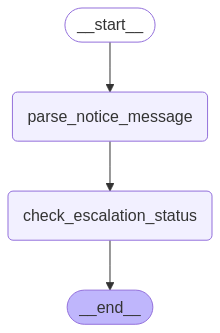

In [9]:
Image(filename='notice_extraction_graph.png')

This visual shows you that state flows from `parse_notice_message` to `check_escalation_status`, and it confirms that you’ve built your graph correctly. Here’s how you use your graph:

In [ ]:
#from example_emails import EMAILS
from devtools import pprint
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH

initial_state = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": "There's a risk of fire or water damage at the site",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

In [ ]:
final_state = NOTICE_EXTRACTION_GRAPH.invoke(initial_state)

In [ ]:
pprint(final_state["notice_email_extract"])

In [ ]:
final_state["requires_escalation"]

In this example, you import `NOTICE_EXTRACTION_GRAPH` and `EMAILS`. You then define your graph’s initial state with `EMAILS[0]` as the `notice_message`, escalation criteria, and a few other fields that you’ll use later in this tutorial. After calling <font color='blue'>NOTICE_EXTRACTION_GRAPH.invoke(initial_state)</font>, your `final_state` stores the extracted notice fields along with the `requires_escalation` flag.

Notice that in `final_state`, `notice_email_extract` is now a <font color='blue'><b>NoticeEmailExtract</b></font> object. Also, `requires_escalation` is set to `False` because `EMAILS[0]` doesn’t say anything about fire or water damage, and the maximum potential fine is less than $100,000.

With that, you’ve built and successfully run your first state graph! If you’re thinking that this graph isn’t any more useful than a chain at this point, you’re correct. <b>In the next section, you’ll address this by learning about and implementing [LangGraph](https://www.langchain.com/langgraph)’s differentiating feature — conditional edges</b>.

### <b><font color='darkgreen'>Work With Conditional Edges</font></b>
<font size='3ptx'><b>[LangGraph](https://www.langchain.com/langgraph) is all about modeling LLM workflows as graphs with nodes and edges</b>. Nodes represent actions that your graph can take like calling functions or invoking chains, and edges tell your graph how to navigate between nodes.</font>

So far, you’ve built a graph with a couple of nodes and edges between them that can’t do much more than a chain. <b>In this section, you’ll learn about <font color='darkblue'>conditional edges</font>, which you can use to move beyond chain-like structures to create intricate, conditional, and even cyclic workflows</b>.

#### <b><font size='3ptx'>Create a Conditional Edge</font></b>
<b><font size='3ptx'>Up to this point, your graph can extract notice fields using `NOTICE_PARSER_CHAIN` and determine whether the notice message requires immediate escalation using `ESCALATION_CHECK_CHAIN`.</font></b>

Next, you’ll see how to change the path your graph takes depending on whether a notice message requires escalation. If a notice message does require escalation, your graph will immediately send an email informing the correct team. If escalation isn’t required, your graph will create a legal ticket using your company’s ticketing system API.

You’ll start by defining a function that sends emails regarding the details of a notice message when the notice requires escalation. Here’s what that looks like:
* **`utils/graph_utils.py`**:
```python
import random
import time
from pydantic import EmailStr
from chains.notice_extraction import NoticeEmailExtract
from utils.logging_config import LOGGER

def send_escalation_email(
    notice_email_extract: NoticeEmailExtract,
    escalation_emails: list[EmailStr]
) -> None:
    """Simulate sending escalation emails"""
    LOGGER.info("Sending escalation emails...")
    for email in escalation_emails:
        time.sleep(1)
        LOGGER.info(f"Escalation email sent to {email}")

def create_legal_ticket(
    current_follow_ups: dict[str, bool] | None,
    notice_email_extract: NoticeEmailExtract,
) -> str | None:
    """Simulate creating a legal ticket using your company's API."""
    LOGGER.info("Creating legal ticket for notice...")
    time.sleep(2)

    follow_ups = [
        None,
        """Does this message mention the states of Texas,
        Georgia, or New Jersey?""",
        """Did this notice involve an issue with FakeAirCo's
        HVAC system?""",
    ]

    if current_follow_ups:
        follow_ups = [
            f for f in follow_ups if f not in current_follow_ups.keys()
        ]
    follow_up = random.choice(follow_ups)
    if not follow_up:
        LOGGER.info("Legal ticket created!")
        return follow_up

    LOGGER.info("Follow-up is required before creating this ticket")
    return follow_up
```

Here, you import dependencies and create a function called <font color='blue'>send_escalation_email()</font>, which accepts a <font color='blue'><b>NoticeEmailExtract</b></font> and a list of addresses to send emails to. Since actually sending emails is beyond the scope of this tutorial, <font color='blue'>send_escalation_email()</font> simply simulates the process. For now, imagine that it sends an email to each address in `escalation_emails` regarding the details stored in <font color='blue'><b>NoticeEmailExtract</b></font>.

You then define <font color='blue'>create_legal_ticket()</font> to simulate creating a ticket for your company’s legal team to investigate. Notice how the first argument <font color='blue'>create_legal_ticket()</font> is a dictionary with `string` keys and `Boolean` values called `current_follow_ups`.

One feature of your legal team’s ticketing system API is that it occasionally requires you to answer yes/no follow-up questions. These questions can change at any time depending on what the legal team is interested in knowing, so it’s difficult to know what the follow-up questions might be ahead of time.

To simulate this logic, <font color='blue'>create_legal_ticket()</font> checks the follow-up questions that you’ve already answered, and it randomly picks a new follow-up question from the remaining questions. If follow-up isn’t required, <font color='blue'>create_legal_ticket()</font> creates a legal ticket and returns None. If follow-up is required, <font color='blue'>create_legal_ticket()</font> returns the follow-up question, and you’ll see how to handle this in your graph later on.

Next, you’ll wrap <font color='blue'>send_escalation_email()</font> and <font color='blue'>create_legal_ticket()</font> in nodes that can interact with your graph’s state:
* **`graphs/notice_extraction.py`**:
```python
...
from utils.graph_utils import create_legal_ticket, send_escalation_email

# ...

def send_escalation_email_node(state: GraphState) -> GraphState:
    """Send an escalation email"""
    send_escalation_email(
        notice_email_extract=state["notice_email_extract"],
        escalation_emails=state["escalation_emails"],
    )
    return state

def create_legal_ticket_node(state: GraphState) -> GraphState:
    """Node to create a legal ticket"""
    follow_up = create_legal_ticket(
        current_follow_ups=state.get("follow_ups"),
        notice_email_extract=state["notice_email_extract"],
    )
    state["current_follow_up"] = follow_up
    return state

# ...
```

After importing your utility functions, you define two new node functions. In <font color='blue'>send_escalation_email_node()</font>, you call <font color='blue'>send_escalation_email()</font> without modifying state. Conversely, in <font color='blue'>create_legal_ticket_node()</font>, you call <font color='blue'>create_legal_ticket()</font> and store the `follow_up` question, if there is one, in `state`.

Now onto the critical part of this section. You need to create a conditional edge based on whether a notice email requires escalation. Specifically, if a notice email does require escalation, then your graph needs to pass state to <font color='blue'>send_escalation_email_node()</font> before creating a legal ticket. If no escalation is required, then your graph can move directly to <font color='blue'>create_legal_ticket_node()</font>.

Here’s how you can create this behavior in your graph:
```python
# ...

def route_escalation_status_edge(state: GraphState) -> str:
    """Determine whether to send an escalation email or
    create a legal ticket"""
    if state["requires_escalation"]:
        LOGGER.info("Escalation needed!")
        return "send_escalation_email"

    LOGGER.info("No escalation needed")
    return "create_legal_ticket"

workflow.add_node("parse_notice_message", parse_notice_message_node)
workflow.add_node("check_escalation_status", check_escalation_status_node)
workflow.add_node("send_escalation_email", send_escalation_email_node)
workflow.add_node("create_legal_ticket", create_legal_ticket_node)

workflow.add_edge(START, "parse_notice_message")
workflow.add_edge("parse_notice_message", "check_escalation_status")
workflow.add_conditional_edges(
    "check_escalation_status",
    route_escalation_status_edge,
    {
        "send_escalation_email": "send_escalation_email",
        "create_legal_ticket": "create_legal_ticket",
    },
)
workflow.add_edge("send_escalation_email", "create_legal_ticket")
workflow.add_edge("create_legal_ticket", END)

NOTICE_EXTRACTION_GRAPH = workflow.compile()
```

Here’s what your graph looks like now:
![part2 graph](https://realpython.com/cdn-cgi/image/width=1618,format=auto/https://files.realpython.com/media/Screenshot_2025-01-19_at_11.24.08_PM.fb5f18a97d55.png)


You now see dotted lines representing the conditional edge flowing out of `check_escalation_status` into <font color='blue'>send_escalation_email</font> and <font color='blue'>create_legal_ticket</font>. As expected, if escalation is needed, your graph goes to <font color='blue'>send_escalation_email</font> before <font color='blue'>create_legal_ticket</font>. Otherwise, your graph flows directly to <font color='blue'>create_legal_ticket</font>.

To see your conditional edge in action, try this example:

In [2]:
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH2
from example_emails import EMAILS

In [3]:
initial_state_no_escalation = {
     "notice_message": EMAILS[0],
     "notice_email_extract": None,
     "escalation_text_criteria": """There's a risk of water
      damage at the site""",
     "escalation_dollar_criteria": 100_000,
     "requires_escalation": False,
     "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

initial_state_escalation = {
     "notice_message": EMAILS[0],
     "notice_email_extract": None,
     "escalation_text_criteria": """Workers explicitly violating
      safety protocols""",
     "escalation_dollar_criteria": 100_000,
     "requires_escalation": False,
     "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

Firstly, below state won't cause escalation:

In [4]:
no_esc_result = NOTICE_EXTRACTION_GRAPH2.invoke(initial_state_no_escalation)

2025-04-26 08:11:03,927 - INFO - Parsing notice...
2025-04-26 08:11:11,308 - INFO - Determining escalation status...
2025-04-26 08:11:12,872 - INFO - No escalation needed
2025-04-26 08:11:12,874 - INFO - Creating legal ticket for notice...
2025-04-26 08:11:15,367 - INFO - Legal ticket created!


In [5]:
no_esc_result["requires_escalation"]

False

Secondly, below state will create escalation:

In [6]:
esc_result = NOTICE_EXTRACTION_GRAPH2.invoke(initial_state_escalation)

2025-04-26 08:14:03,352 - INFO - Parsing notice...
2025-04-26 08:14:07,436 - INFO - Determining escalation status...
2025-04-26 08:14:18,487 - INFO - Escalation needed!
2025-04-26 08:14:18,514 - INFO - Sending escalation emails...
2025-04-26 08:14:19,518 - INFO - Escalation email sent to brog@abc.com
2025-04-26 08:14:20,529 - INFO - Escalation email sent to bigceo@company.com
2025-04-26 08:14:20,531 - INFO - Creating legal ticket for notice...
2025-04-26 08:14:22,536 - INFO - Follow-up is required before creating this ticket


In [7]:
esc_result["requires_escalation"]

True

<font size='3ptx'><b>Your graph now moves beyond the limitations of chains by handling conditional workflows.</b></font> Take a moment to think about why the conditional edge abstraction is so powerful. Most meaningful real-world tasks involve several decisions that change the trajectory of steps you take. Trying to replicate this behavior with chains would require a lot of boilerplate conditional and iterative logic, and it would quickly get out of hand as your graph grows.

Now what about those follow-up questions? <b>If the legal ticketing API returns a follow-up question, how can you answer it and attempt to create a legal ticket again? The answer lies in cycles, and that’s what you’ll explore next</b>.

### <b><font color='darkgreen'>Use Conditional Edges for Cycles</font></b>
<font size='3ptx'><b>The last capability you’ll explore for your notice extraction graph is a cycle</b>. A graph cycle is effectively a loop between two nodes that continues until a task is complete</font>. 

<b>In this section, you’ll build a cycle between the node that creates legal tickets and a new node that answers the follow-up questions.</b>

If you recall from the last section, sometimes the legal ticketing API returns follow-up questions that you’re required to answer before creating the ticket. You want to build a cycle that receives and answers the follow-up questions from the legal ticket node until no other follow-up questions are required. To keep things simple for this tutorial, these questions will always have binary yes or no answers.

First, create a chain that you’ll use to answer binary questions:
- **`chains/binary_questions.py`**:
```python
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class BinaryAnswer(BaseModel):
    is_true: bool = Field(
        description="""Whether the answer to the question is yes or no.
        True if yes otherwise False."""
    )

binary_question_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Answer this question as True for "yes" and False for "no".
            No other answers are allowed:

            {question}
            """,
        )
    ]
)

binary_question_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

BINARY_QUESTION_CHAIN = (
    binary_question_prompt
    | binary_question_model.with_structured_output(BinaryAnswer)
)
```

Next, you’ll create a node in your graph that uses `BINARY_QUESTION_CHAIN` to answer follow-up questions:
* **`graphs/notice_extraction.py`**:
```python
...
from chains.binary_questions import BINARY_QUESTION_CHAIN

# ...

def answer_follow_up_question_node(state: GraphState) -> GraphState:
    """Answer follow-up questions about the notice using
    BINARY_QUESTION_CHAIN"""
    if state["current_follow_up"]:
        question = state["current_follow_up"] + " " + state["notice_message"]
        answer = BINARY_QUESTION_CHAIN.invoke({"question": question})
        if state.get("follow_ups"):
            state["follow_ups"][state["current_follow_up"]] = answer
        else:
            state["follow_ups"] = {state["current_follow_up"]: answer}
    return state

# ...
```

Now you need to create a function to define the conditional edge between the create legal ticket and answer follow-up question nodes:
* **`graphs/notice_extraction.py`**:
```python
# ...

def route_follow_up_edge(state: GraphState) -> str:
    """Determine whether a follow-up question is required"""
    if state.get("current_follow_up"):
        return "answer_follow_up_question"
    return END

# ...
```

Now, you can register your new node and create the conditional edge:
* **`graphs/notice_extraction.py`**:
```python
workflow3 = StateGraph(GraphState)
workflow3.add_node("parse_notice_message", parse_notice_message_node)
workflow3.add_node("check_escalation_status", check_escalation_status_node)
workflow3.add_node("send_escalation_email", send_escalation_email_node)
workflow3.add_node("create_legal_ticket", create_legal_ticket_node)
workflow3.add_node("answer_follow_up_question", answer_follow_up_question_node)

workflow3.add_edge(START, "parse_notice_message")
workflow3.add_edge("parse_notice_message", "check_escalation_status")
workflow3.add_conditional_edges(
    "check_escalation_status",
    route_escalation_status_edge,
    {
        "send_escalation_email": "send_escalation_email",
        "create_legal_ticket": "create_legal_ticket",
    },
)
workflow3.add_conditional_edges(
    "create_legal_ticket",
    route_follow_up_edge,
    {
        "answer_follow_up_question": "answer_follow_up_question",
        END: END,
    },
)

workflow3.add_edge("send_escalation_email", "create_legal_ticket")
workflow3.add_edge("answer_follow_up_question", "create_legal_ticket")

NOTICE_EXTRACTION_GRAPH3 = workflow.compile()
```

In [3]:
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH3

In [4]:
image_data = NOTICE_EXTRACTION_GRAPH3.get_graph().draw_mermaid_png()
with open('notice_extraction_graph3.png', mode='wb') as f:
    f.write(image_data)

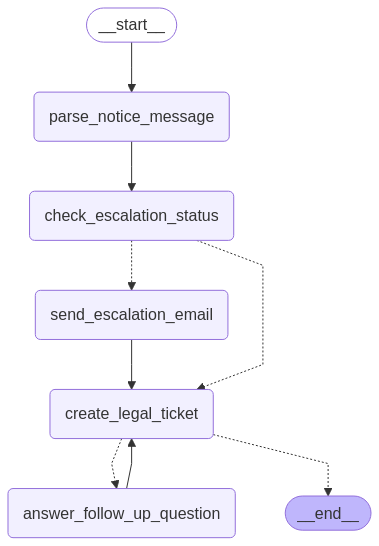

In [5]:
Image(filename='notice_extraction_graph3.png')

Go ahead and give your updated graph a test run:

In [7]:
from example_emails import EMAILS

initial_state_escalation = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": """Workers explicitly violating safety protocols""",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

In [8]:
results = NOTICE_EXTRACTION_GRAPH3.invoke(initial_state_escalation)

2025-04-26 08:38:55,204 - INFO - Parsing notice...
2025-04-26 08:39:01,461 - INFO - Determining escalation status...
2025-04-26 08:39:02,527 - INFO - Escalation needed!
2025-04-26 08:39:02,532 - INFO - Sending escalation emails...
2025-04-26 08:39:03,565 - INFO - Escalation email sent to brog@abc.com
2025-04-26 08:39:05,184 - INFO - Escalation email sent to bigceo@company.com
2025-04-26 08:39:05,188 - INFO - Creating legal ticket for notice...
2025-04-26 08:39:07,204 - INFO - Follow-up is required before creating this ticket
2025-04-26 08:39:08,123 - INFO - Creating legal ticket for notice...
2025-04-26 08:39:10,555 - INFO - Legal ticket created!


In [9]:
results["follow_ups"]

{"Did this notice involve an issue with FakeAirCo's\n        HVAC system?": BinaryAnswer(is_true=False)}

With that, you’ve completed your notice email processing graph. Nice work! Hopefully, you’re seeing the power of LangGraph to create sophisticated, conditional, and cyclic LLM workflows. From here, you can continue adding any functionality that you can imagine by creating nodes to accomplish tasks and adding edges to navigate between them.

In the next and final section, you’ll add some nice finishing touches to your notice email processing graph. You’ll use LangGraph to create an agent that can handle any kind of email and use `NOTICE_EXTRACTION_GRAPH3` as one of its tools.

## <b><font color='darkblue'>Develop Graph Agents</font></b>
<b><font size='3ptx'>Now it’s time to complete your email-parsing system by creating an agent with [LangGraph](https://www.langchain.com/langgraph).</font></b>

If you’re unfamiliar with agents, you can read about them in the [**LangChain tutorial**](https://realpython.com/build-llm-rag-chatbot-with-langchain/#agents). In short, an AI agent is a system of AI models, usually LLMs, capable of performing tasks and making decisions autonomously.

The two main components of an agent are:
* The models that make decisions.
* The tools the models use to perform actions.

<font size='3ptx'>**[LangGraph](https://www.langchain.com/langgraph) was designed with agents in mind because agent architectures tend to be conditional and cyclic in nature.**</font> The agent you’ll create in this section will govern email processing, and it will have access to tools that can send emails and call `NOTICE_EXTRACTION_GRAPH3` when it determines that an email is a regulatory notice.

### <b><font color='darkgreen'>Structure Agents as Graphs</font></b>
To get started building your email processing agent, first import the following dependencies:
* **`graphs/email_agent.py`**:
```python
import time
from chains.notice_extraction import NoticeEmailExtract
from graphs.notice_extraction import NOTICE_EXTRACTION_GRAPH
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from utils.logging_config import LOGGER
```

Most of these imports should look familiar, but notice that you’ve imported [**MessagesState**](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) instead of **<font color='blue'>GraphState</font>**. [**MessagesState**](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) is a predefined **<font color='blue'>GraphState</font>** that has only one attribute called `messages`. Each node in your agent graph will append its output to messages in [**MessagesState**](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). [**MessagesState**](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) comes with some nice features that make creating agents easier, and you’ll see these in a moment.

Also, notice that you’ve imported the [**ToolNode**](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) class from `langgraph.prebuilt`. [**ToolNode**](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) **allows you to create nodes in your graph explicitly designed for providing tools to agent nodes. In both LangChain and LangGraph, a tool is nothing more than a function your agent models can call to perform actions**. Here are the tools you’ll need for your email agent:

- **`graphs/email_agent.py`**:
```python
# ...

@tool
def forward_email(email_message: str, send_to_email: str) -> bool:
    """
    Forward an email_message to the address of send_to_email. Returns
    true if the email was successful otherwise it wil return false. Note
    that this tool only forwards the email to an internal department -
    it does not reply to the sender.
    """
    LOGGER.info(f"Forwarding the email to {send_to_email}...")
    time.sleep(2)
    LOGGER.info("Email forwarded!")
    return True

@tool
def send_wrong_email_notification_to_sender(
    sender_email: str, correct_department: str
):
    """
    Send an email back to the sender informing them that
    they have the wrong address. The email should be sent
    to the correct_department.
    """
    LOGGER.info(f"Sending wrong email notification to {sender_email}...")
    time.sleep(2)
    LOGGER.info("Email sent!")
    return True

@tool
def extract_notice_data(
    email: str, escalation_criteria: str
) -> NoticeEmailExtract:
    """
    Extract structured fields from a regulatory notice.
    This should be used when the email message comes from
    a regulatory body or auditor regarding a property or
    construction site that the company works on.

    escalation_criteria is a description of which kinds of
    notices require immediate escalation.

    After calling this tool, you don't need to call any others.
    """
    LOGGER.info("Calling the email notice extraction graph...")
    initial_state = {
        "notice_message": email,
        "notice_email_extract": None,
        "critical_fields_missing": False,
        "escalation_text_criteria": escalation_criteria,
        "escalation_dollar_criteria": 100_000,
        "requires_escalation": False,
        "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
    }

    results = NOTICE_EXTRACTION_GRAPH.invoke(initial_state)
    return results["notice_email_extract"]

@tool
def determine_email_action(email: str) -> str:
    """
    Call to determine which action should be taken
    for an email. Only use when the other tools don't seem
    relevant for the email task. Do not call this tool if
    you've already called extract_notice_data.
    """
    return """
    If the email appears to be an invoice of any kind or related to
    billing, forward the email to the billing and invoices team:
    billing@company.com and send a wrong email notice back to the
    sender. The correct department is billing@company.com.

    If the email appears to be from a customer, forward to
    support@company.com, cdetuma@company.com, and ctu@abc.com.
    Be sure to forward it to all three emails listed.
    Send a wrong email notice back to the
    customer and let them know the correct department is
    support@company.com.

    For any other emails, please send a wrong email notification
    and try to infer the correct department from one of
    billing@company.com, support@company.com,
    humanresources@company.com, and it@company.com.
    """
```

The functions you defined above are the tools your agent will use, and each function is decorated by <font color='orange'><b>@tool</b></font>. A key functionality of <font color='orange'><b>@tool</b></font> is that it gives the function’s docstring to your agent’s LLM, helping it determine whether that particular tool is relevant to the task at hand. Because of this, <b>it’s important to write informative docstrings to maximize the chances that your agent uses the appropriate tools</b>.

As an example of how your agent will use these tools, if the agent determines that it needs to forward an email, the agent’s underlying LLM will return a JSON string with the appropriate `email_message` and `send_to_email` parameters. Your graph will convert this JSON to a dictionary and pass it to <font color='blue'>forward_email()</font>.

Perhaps the most powerful tool available to your agent is <font color='blue'>extract_notice_data()</font>. Your agent should call <font color='blue'>extract_notice_data()</font> when it determines that an email is a regulatory notice, and invoke your `NOTICE_EXTRACTION_GRAPH3`. This is an amazing abstraction—because tools are nothing more than functions, you can use them to call other chains, graphs, and agents, and perform just about any task that you can encapsulate in a function.

The last tool you define, <font color='blue'>determine_email_action()</font>, should be used when your agent receives an email that it doesn’t know how to process. In <font color='blue'>determine_email_action()</font>, you can see that a set of instructions are predefined, but this tool could be another LLM trained to make decisions about what to do with your company’s emails.

Next, you need to define the nodes and edges of your agent graph:
- **`graphs/email_agent.py`**:
```python
# ...

tools = [
    determine_email_action,
    forward_email,
    send_wrong_email_notification_to_sender,
    extract_notice_data,
]
tool_node = ToolNode(tools)
EMAIL_AGENT_MODEL = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(
    tools
)

def call_agent_model_node(state: MessagesState) -> dict[str, list[AIMessage]]:
    """Node to call the email agent model"""
    messages = state["messages"]
    response = EMAIL_AGENT_MODEL.invoke(messages)
    return {"messages": [response]}

def route_agent_graph_edge(state: MessagesState) -> str:
    """Determine whether to call more tools or exit the graph"""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "email_tools"
    return END
```

You first instantiate a [**ToolNode**](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) that can call the four tool functions you defined above. Keep in mind that `tool_node` only executes your tool functions, and <b>knowing which tool to use is the agent node’s responsibility. You then instantiate `EMAIL_AGENT_MODEL`, which is the LLM that acts as your agent’s brain</b>.

By calling `.bind_tools()` when instantiating `EMAIL_AGENT_MODEL`, you’re giving the agent LLM descriptions of each tool from their docstring and input arguments. If your agent LLM determines that its input requires a tool call, it’ll return a JSON tool message with the name of the tool it wants to use, along with the input arguments.

In <font color='blue'>call_agent_model_node()</font>, you define the logic for invoking `EMAIL_AGENT_MODEL`. In this case, your email agent node simply takes the messages in `state` and passes them to <font color='blue'>EMAIL_AGENT_MODEL.invoke()</font>. You might notice here that you’re not directly modifying the state in <font color='blue'>call_agent_model_node()</font>, but under the hood, LangGraph will automatically append response to your graph’s state. You can read more about how this works in [LangGraph’s documentation](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate).

Lastly, you define <font color='blue'>route_agent_graph_edge()</font>, which governs the conditional edge between your agent and tool nodes. If the most recent message in state is a tool, your graph moves to `tool_node` which is aliased to `email_tools`. Otherwise, you terminate the graph. This will make more sense once you instantiate and visualize your graph. Here’s the last few lines you need for your graph agent:
- **`graphs/email_agent.py`**:
```python
workflow = StateGraph(MessagesState)

workflow.add_node("email_agent", call_agent_model_node)
workflow.add_node("email_tools", tool_node)

workflow.add_edge(START, "email_agent")
workflow.add_conditional_edges(
    "email_agent", route_agent_graph_edge, ["email_tools", END]
)
workflow.add_edge("email_tools", "email_agent")

email_agent_graph = workflow.compile()
```

You first instantiate workflow—a StateGraph that passes around a [**MessagesState**](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) object. Then, you add the `email_agent` and `email_tool` nodes to your graph and create the edges between them. The first edge moves from `START` to `email_agent` where `email_agent` will process the first message in your graph. In this case, the first message will be an email. You then add the conditional edge between `email_agent`, `email_tools`, and `END`.

As specified in <font color='blue'>route_agent_graph_edge()</font>, if the `email_agent` node returns a tool message, your graph moves to the `email_tools` node to call the respective tool. The last edge you define connects `email_tools` back to `email_agent`, creating a cycle between the two. This means that the `email_agent` and `email_tools` nodes will continuously pass information back and forth until `email_agent` returns a non-tool message.

Zooming out, here’s what your email agent looks like:

In [10]:
from graphs.email_agent import email_agent_graph

In [11]:
image_data = email_agent_graph.get_graph().draw_mermaid_png()
with open('email_agent_graph.png', mode='wb') as f:
    f.write(image_data)

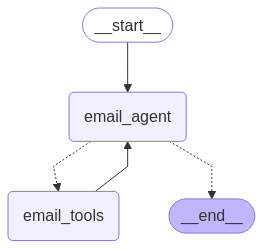

In [12]:
Image(filename='email_agent_graph.png')

This architecture, while straightforward, is very common and a great place to start when building agents. <b>The general idea is that your `email_agent` will accept an email message and continually call `email_tools` until it believes it has successfully processed the email.</b> From here, you can continue expanding your agent’s capabilities. The last thing to do now is give your agent a try and see how it performs on a few examples.

### <b><font color='darkgreen'>Test Your Graph Agent</font></b>
<b><font size='3ptx'>Your email graph agent is complete and ready for you to test! In practice, it’s a good idea to test your agents on several examples where you know what the desired behavior should be.</font></b>

This way, you can measure your agent’s performance and adjust its architecture and prompts to improve it. However, for this tutorial, you’ll just empirically inspect how your agent responds to the example emails you defined earlier.

Given these four emails, here’s how you might expect your agent to respond to each:
* **Email 0**: This email is clearly a regulatory notice, and your agent should call your notice extraction graph. Since you’ve used this example several times now, you’ll skip it for this section.
* **Email 1**: This email looks like it’s an invoice that doesn’t come from any kind of regulatory body or inspector. Your email agent should forward this to the billing department and send an email to debby@stack.com, informing her that she has the wrong email address.
* **Email 2**: This email comes from a customer that’s having issues with equipment your company installed. Your agent should forward it to customer support, and it should send an email back to tdavid@companyxyz.com telling him that he has the wrong address.
* **Email 3**: This email is clearly a regulatory notice, and your agent should call your notice extraction graph.

To see how your agent does, let's handle once mail upon a time:

In [19]:
from graphs.email_agent import email_agent_graph
from example_emails import EMAILS
from pprint import pprint

#### <b><font size='3ptx'>Email 1</font></b>

In [20]:
message_1 = {"messages": [("human", EMAILS[1])]}
pprint(message_1)

{'messages': [('human',
               '\n'
               '    From: debby@stack.com\n'
               '    Hey Betsy,\n'
               "    Here's your invoice for $1000 for the cookies you "
               'ordered.\n'
               '    ')]}


In [16]:
for chunk in email_agent_graph.stream(message_1, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================


    From: debby@stack.com
    Hey Betsy,
    Here's your invoice for $1000 for the cookies you ordered.
    
================================== Ai Message ==================================
Tool Calls:
  determine_email_action (call_pE40Cxzch4AJeDaXfO6RXwJV)
 Call ID: call_pE40Cxzch4AJeDaXfO6RXwJV
  Args:
    email: From: debby@stack.com
Hey Betsy,
Here's your invoice for $1000 for the cookies you ordered.
================================= Tool Message =================================
Name: determine_email_action


    If the email appears to be an invoice of any kind or related to
    billing, forward the email to the billing and invoices team:
    billing@company.com and send a wrong email notice back to the
    sender. The correct department is billing@company.com.

    If the email appears to be from a customer, forward to
    support@company.com, cdetuma@company.com, and ctu@abc.com.
    Be sure to

2025-04-26 09:29:36,872 - INFO - Forwarding the email to billing@company.com...
2025-04-26 09:29:36,876 - INFO - Sending wrong email notification to debby@stack.com...


================================== Ai Message ==================================
Tool Calls:
  forward_email (call_IWRC8RZYokqoCs2qS66jrwnB)
 Call ID: call_IWRC8RZYokqoCs2qS66jrwnB
  Args:
    email_message: From: debby@stack.com
Hey Betsy,
Here's your invoice for $1000 for the cookies you ordered.
    send_to_email: billing@company.com
  send_wrong_email_notification_to_sender (call_IAl0ro0oBkXEMttwJ5DZXf5G)
 Call ID: call_IAl0ro0oBkXEMttwJ5DZXf5G
  Args:
    sender_email: debby@stack.com
    correct_department: billing@company.com


2025-04-26 09:29:39,421 - INFO - Email forwarded!
2025-04-26 09:29:39,438 - INFO - Email sent!


================================= Tool Message =================================
Name: send_wrong_email_notification_to_sender

true
================================== Ai Message ==================================

The email has been successfully forwarded to the billing department, and a notification has been sent to the sender, informing them that they have the wrong address and that the correct department is billing@company.com.


Here’s what happens:
1. Your agent calls <font color='blue'>determine_email_action()</font> to get instructions.
2. Based on these instructions, your agent forwards the email to `billing@company.com`.
3. It also sends a wrong email notification to `debby@stack.com`.

Your agent behaved exactly like you wanted it to!

#### <b><font size='3ptx'>Email 2</font></b>

In [22]:
message_2 = {"messages": [("human", EMAILS[2])]}
pprint(message_2)

{'messages': [('human',
               '\n'
               '    From: tdavid@companyxyz.com\n'
               '    Hi Paul,\n'
               '    We have an issue with the HVAC system your team installed '
               'in\n'
               "    apartment 1235. We'd like to request maintenance or a "
               'refund.\n'
               '    Thanks,\n'
               '    Terrance\n'
               '    ')]}


In [23]:
for chunk in email_agent_graph.stream(message_2, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================


    From: tdavid@companyxyz.com
    Hi Paul,
    We have an issue with the HVAC system your team installed in
    apartment 1235. We'd like to request maintenance or a refund.
    Thanks,
    Terrance
    
================================== Ai Message ==================================
Tool Calls:
  determine_email_action (call_1fNuGeESqdOboiADlWesXB5a)
 Call ID: call_1fNuGeESqdOboiADlWesXB5a
  Args:
    email: From: tdavid@companyxyz.com
Hi Paul,
We have an issue with the HVAC system your team installed in apartment 1235. We'd like to request maintenance or a refund.
Thanks,
Terrance
================================= Tool Message =================================
Name: determine_email_action


    If the email appears to be an invoice of any kind or related to
    billing, forward the email to the billing and invoices team:
    billing@company.com and send a wrong email notice back to the
    sender. Th

2025-04-26 09:35:51,756 - INFO - Forwarding the email to support@company.com...
2025-04-26 09:35:51,770 - INFO - Forwarding the email to cdetuma@company.com...
2025-04-26 09:35:51,777 - INFO - Forwarding the email to ctu@abc.com...
2025-04-26 09:35:51,787 - INFO - Sending wrong email notification to tdavid@companyxyz.com...


================================== Ai Message ==================================
Tool Calls:
  forward_email (call_nC5U9PpzSS8kEsUkDic4ACu5)
 Call ID: call_nC5U9PpzSS8kEsUkDic4ACu5
  Args:
    email_message: From: tdavid@companyxyz.com
Hi Paul,
We have an issue with the HVAC system your team installed in apartment 1235. We'd like to request maintenance or a refund.
Thanks,
Terrance
    send_to_email: support@company.com
  forward_email (call_LgMfgB51to7cHEeLw1R4eO6w)
 Call ID: call_LgMfgB51to7cHEeLw1R4eO6w
  Args:
    email_message: From: tdavid@companyxyz.com
Hi Paul,
We have an issue with the HVAC system your team installed in apartment 1235. We'd like to request maintenance or a refund.
Thanks,
Terrance
    send_to_email: cdetuma@company.com
  forward_email (call_1XBxinaPsS18wBsQFgd4XSXy)
 Call ID: call_1XBxinaPsS18wBsQFgd4XSXy
  Args:
    email_message: From: tdavid@companyxyz.com
Hi Paul,
We have an issue with the HVAC system your team installed in apartment 1235. We'd like to req

2025-04-26 09:35:53,770 - INFO - Email forwarded!
2025-04-26 09:35:53,790 - INFO - Email forwarded!
2025-04-26 09:35:53,797 - INFO - Email forwarded!
2025-04-26 09:35:53,802 - INFO - Email sent!


================================= Tool Message =================================
Name: send_wrong_email_notification_to_sender

true
================================== Ai Message ==================================

The email has been successfully forwarded to the support team and the other relevant contacts. Additionally, a notification has been sent to the sender, informing them that the correct department is support@company.com.


For the second email, here’s what happens:
1. Your agent recognizes that it comes from a customer and successfully forwards it to the three customer support emails listed in the instructions.
2. It then sends a wrong email notification back to `tdavid@companyxyz.com`.
3. This means your agent made a total of five tool calls before terminating the graph — it determined the email action, forwarded the email to three different addresses, and sent a wrong email notification.

#### <b><font size='3ptx'>Email 3</font></b>

In [27]:
escalation_criteria = """"There's an immediate risk of electrical, water, or fire damage"""

message_with_criteria = f"""
The escalation criteria is: {escalation_criteria}

Here's the email:

{EMAILS[3]}
"""

In [28]:
message_3 = {"messages": [("human", message_with_criteria)]}
pprint(message_3)

{'messages': [('human',
               '\n'
               'The escalation criteria is: "There\'s an immediate risk of '
               'electrical, water, or fire damage\n'
               '\n'
               "Here's the email:\n"
               '\n'
               '\n'
               '    Date: January 10, 2025\n'
               '    From: City of Los Angeles Building and Safety Department\n'
               '    To: West Coast Development, project 345678123 - Sunset '
               'Luxury\n'
               '    Condominiums\n'
               '    Location: Los Angeles, CA\n'
               '    Following an inspection of your site at 456 Sunset '
               'Boulevard, we have\n'
               '    identified the following building code violations:\n'
               '    Electrical Wiring: Exposed wiring was found in the '
               'underground parking\n'
               '    garage, posing a safety hazard. Fire Safety: Insufficient '
               'fire\n'
              

In [29]:
for chunk in email_agent_graph.stream(message_3, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================


The escalation criteria is: "There's an immediate risk of electrical, water, or fire damage

Here's the email:


    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring 

2025-04-26 09:39:32,071 - INFO - Calling the email notice extraction graph...
2025-04-26 09:39:32,075 - INFO - Parsing notice...


================================== Ai Message ==================================
Tool Calls:
  extract_notice_data (call_WK47TR8CXLtYtYqNlFaKfQM9)
 Call ID: call_WK47TR8CXLtYtYqNlFaKfQM9
  Args:
    email: Date: January 10, 2025
From: City of Los Angeles Building and Safety Department
To: West Coast Development, project 345678123 - Sunset Luxury
Condominiums
Location: Los Angeles, CA
Following an inspection of your site at 456 Sunset Boulevard, we have
identified the following building code violations:
Electrical Wiring: Exposed wiring was found in the underground parking
garage, posing a safety hazard. Fire Safety: Insufficient fire
extinguishers were available across multiple floors of the structure
under construction.
Structural Integrity: The temporary support beams in the eastern wing
do not meet the load-bearing standards specified in local building
codes.
Required Corrective Actions:
Replace or properly secure exposed wiring to meet electrical safety
standards. Install additiona

2025-04-26 09:39:35,326 - INFO - Determining escalation status...
2025-04-26 09:39:36,592 - INFO - Escalation needed!
2025-04-26 09:39:36,601 - INFO - Sending escalation emails...
2025-04-26 09:39:38,591 - INFO - Escalation email sent to brog@abc.com
2025-04-26 09:39:39,626 - INFO - Escalation email sent to bigceo@company.com
2025-04-26 09:39:39,666 - INFO - Creating legal ticket for notice...
2025-04-26 09:39:41,686 - INFO - Follow-up is required before creating this ticket
2025-04-26 09:39:42,819 - INFO - Creating legal ticket for notice...
2025-04-26 09:39:44,857 - INFO - Follow-up is required before creating this ticket
2025-04-26 09:39:45,623 - INFO - Creating legal ticket for notice...
2025-04-26 09:39:47,628 - INFO - Legal ticket created!


================================= Tool Message =================================
Name: extract_notice_data

entity_name='City of Los Angeles Building and Safety Department' entity_phone='(555) 456-7890' entity_email='inspections@lacity.gov' project_id=345678123 site_location='456 Sunset Boulevard, Los Angeles, CA' violation_type='Electrical Wiring, Fire Safety, Structural Integrity' required_changes='Replace or properly secure exposed wiring to meet electrical safety standards. Install additional fire extinguishers in compliance with fire code requirements. Reinforce or replace temporary support beams to ensure structural stability.' max_potential_fine=None date_of_notice=datetime.date(2025, 1, 10) compliance_deadline=datetime.date(2025, 2, 5)
================================== Ai Message ==================================

The notice from the City of Los Angeles Building and Safety Department has been successfully extracted. Here are the details:

- **Entity Name**: City of Los Angele

Here’s what happens for this one:
1. You first define `escalation_criteria` and create a message that includes `escalation_criteria` with the email message.
2. Your agent successfully recognizes that this is a notice email, and it calls the `extract_notice_data` tool.
3. This invokes your notice extraction graph, which successfully parses the notice and identifies that it requires escalation.

Your agent worked end-to-end on all three examples, and the results are awesome!

<b>Keep in mind that you might not get the exact same results as above given that LLM outputs aren’t deterministic, but your results should be very similar</b>. You now have the tools—no pun intended—needed to build your own LangGraph agents!

## <b><font color='darkblue'>Conclusion</font></b>
Congratulations on completing this in-depth tutorial! You successfully built an LLM agent in LangGraph and now have a solid foundation to build your own applications.

In this tutorial, you’ve learned how to:
1. Think about LangGraph as a complement to LangChain for building sophisticated LLM workflows
2. Build LangGraph StateGraph workflows with conditional edges and cycles
3. Build LangGraph LLM agents

## <b><font color='darkblue'>Supplement</font></b>
* [Medium - LangGraph for Beginners, Part 4: StateGraph.](https://medium.com/ai-agents/langgraph-for-beginners-part-4-stategraph-794004555369)